<h3><b>Low-Ranked Adaptation Applied to Resnet-18, Resnet-34 and Resnet-50


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torchsummary import summary
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
import matplotlib.pyplot as plt

from PIL import Image
from tempfile import TemporaryDirectory

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cudnn.benchmark = True
plt.ion()

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive"

 0001.jpg
'AAMINA BINTE KHURRAM_CV.pdf'
'AAMINA BINTE KHURRAM CV + Transcript.gdoc'
'AAMINA BINTE KHURRAM CV + Transcript.pdf'
"Aamina's Resume.pdf"
'Aamina - Stuff I need to pack.gsheet'
 adult
'andrew ng ml'
'Assignment 1 - Code Review.pdf'
 auto-mpg.csv
'Bake Sale - 6th May, 2024.xlsx'
'Colab Notebooks'
'dl specialisation'
'Field Studies - FlipBrush'
'FM Projects .gsheet'
 FYDP
 gpt.py
 HBLScreenshotstransaction_04-09-2023T17_07_45.jpg
'HCI assignment 2.gdoc'
'HCI Lab 04.gdoc'
 HCI_Lab06.gdoc
'HCI Lab 10.gdoc'
'ID card.pdf'
 index.gdoc
'integrated satellite networks for 6G'
'integrated satellite networks for 6G (1)'
"Integrated Satellite-Terrestrial Networks - Summer '23"
"Internship'22"
'Jones · SlidesMania.gslides'
'Lab07 HCI.gdoc'
 Lab08_HCI.gdoc
 Machine-Learning-Specialization-Coursera
'ML project'
'Muhammad Ali Mazidi, Janice Gillispie Mazidi, Rolin D. McKinlay - The 8051 Microcontroller and Embedded Systems Using Assembly and C-Pearson (2006).pdf'
'Old Stuff to Keep'
'ONT - S

In [8]:
!unzip -q "/content/drive/My Drive/images dataset.zip" -d "/content/dataset"


replace /content/dataset/autism-2.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dataset/autism-S-224-89.33.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dataset/consolidated/autistic/0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
path = "/content/dataset"


In [21]:
# Define transforms for data augmentation and normalization
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [22]:

train_dataset = datasets.ImageFolder(root=path+"/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = datasets.ImageFolder(root=path+"/valid", transform=transform)
validation_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root=path+"/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train':train_loader, 'valid':validation_loader, 'test':test_loader}

# Determine dataset sizes
dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['valid'] = len(validation_dataset)
dataset_sizes['test'] = len(test_dataset)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
# Define the LORA layer
class LORALayer(nn.Module):
    def __init__(self, adapted_layer, rank=16):
        super(LORALayer, self).__init__()
        self.adapted_layer = adapted_layer
        # Initialize low-rank matrices A and B
        self.A = nn.Parameter(torch.randn(adapted_layer.weight.size(1), rank))
        self.B = nn.Parameter(torch.randn(rank, adapted_layer.weight.size(0)))

    def forward(self, x):
        # Compute the low-rank update
        low_rank_matrix = self.A @ self.B
        adapted_weight = self.adapted_layer.weight + low_rank_matrix.t()  # Ensure correct shape
        return nn.functional.linear(x, adapted_weight, self.adapted_layer.bias)

In [25]:
# Define function for training a model
def train_model(model, criterion, optimizer, dataloaders, num_epochs=5):
    model.to(device)
    train_acc_history = []
    valid_acc_history = []

    train_loss_history = []
    valid_loss_history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                valid_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                valid_loss_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    return model, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

In [26]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1))


<h4><b>ResNet18


In [27]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [28]:
# Modify the model head for fine-tuning

num_features = model.fc.in_features

num_classes = 2

model.fc = nn.Linear(num_features, 2)

# Replace the last fully connected layer with LORALayer for adaptation
model.fc = LORALayer(model.fc)

In [29]:
print(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
model_5_ep, train_acc_resnet18, valid_acc_resnet18, train_loss_resnet18, valid_loss_resnet18 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=5)


Epoch 1/5
----------
train Loss: 9.9224 Acc: 0.7401
valid Loss: 2.6549 Acc: 0.8770
Epoch 2/5
----------
train Loss: 3.3478 Acc: 0.8533
valid Loss: 2.6665 Acc: 0.8884
Epoch 3/5
----------
train Loss: 2.2719 Acc: 0.9046
valid Loss: 2.4739 Acc: 0.8920
Epoch 4/5
----------
train Loss: 1.6741 Acc: 0.9188
valid Loss: 0.7229 Acc: 0.9550
Epoch 5/5
----------
train Loss: 1.4477 Acc: 0.9298
valid Loss: 1.1235 Acc: 0.9424


In [31]:
print("Evaluating resnet18 on the test set...")
evaluate_model(model_5_ep, dataloaders['test'])

Evaluating resnet18 on the test set...
Accuracy: 0.8533
Precision: 0.8193
Recall: 0.9067
F1-score: 0.8608


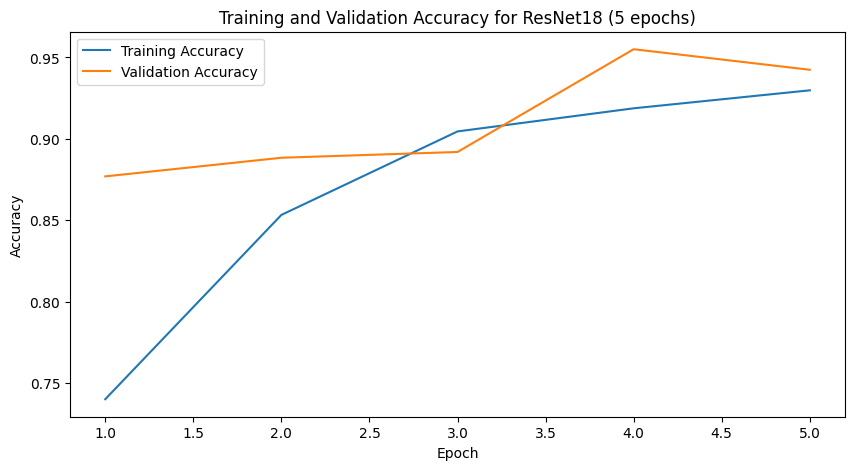

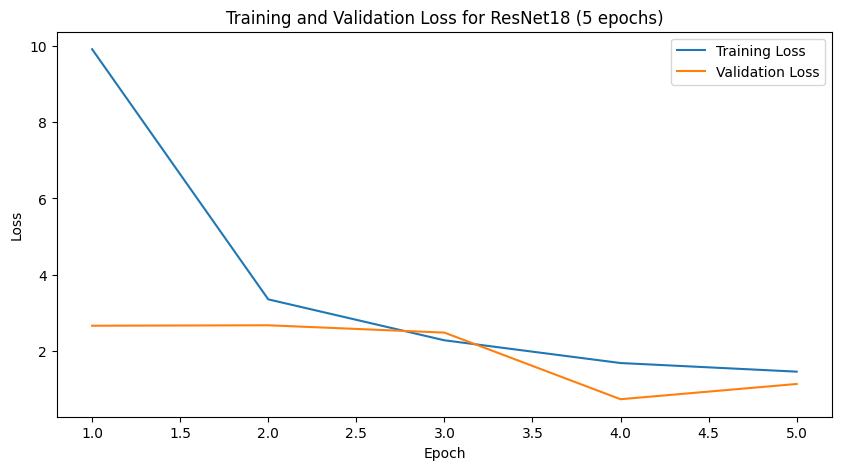

In [33]:
# Move the accuracies to CPU
train_acc_resnet18_cpu = [acc.cpu().numpy() for acc in train_acc_resnet18]
valid_acc_resnet18_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet18]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet18_cpu) + 1), train_acc_resnet18_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet18_cpu) + 1), valid_acc_resnet18_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet18 (5 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet18) + 1), train_loss_resnet18, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet18) + 1), valid_loss_resnet18, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet18 (5 epochs)')
plt.legend()
plt.show()

In [34]:
model_10_ep, train_acc_resnet18, valid_acc_resnet18, train_loss_resnet18, valid_loss_resnet18 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=10)


Epoch 1/10
----------
train Loss: 1.0071 Acc: 0.9432
valid Loss: 0.7323 Acc: 0.9570
Epoch 2/10
----------
train Loss: 1.3395 Acc: 0.9310
valid Loss: 0.9107 Acc: 0.9507
Epoch 3/10
----------
train Loss: 0.9325 Acc: 0.9527
valid Loss: 0.7527 Acc: 0.9590
Epoch 4/10
----------
train Loss: 0.8057 Acc: 0.9594
valid Loss: 0.6560 Acc: 0.9633
Epoch 5/10
----------
train Loss: 0.7538 Acc: 0.9614
valid Loss: 1.9024 Acc: 0.9267
Epoch 6/10
----------
train Loss: 1.0382 Acc: 0.9550
valid Loss: 0.7349 Acc: 0.9594
Epoch 7/10
----------
train Loss: 0.7858 Acc: 0.9641
valid Loss: 0.1645 Acc: 0.9854
Epoch 8/10
----------
train Loss: 0.6533 Acc: 0.9653
valid Loss: 0.2582 Acc: 0.9819
Epoch 9/10
----------
train Loss: 0.5052 Acc: 0.9696
valid Loss: 0.3909 Acc: 0.9799
Epoch 10/10
----------
train Loss: 0.5994 Acc: 0.9661
valid Loss: 0.2820 Acc: 0.9823


In [35]:
print("Evaluating resnet18 on the test set...")
evaluate_model(model_10_ep, dataloaders['test'])

Evaluating resnet18 on the test set...
Accuracy: 0.8800
Precision: 0.8851
Recall: 0.8733
F1-score: 0.8792


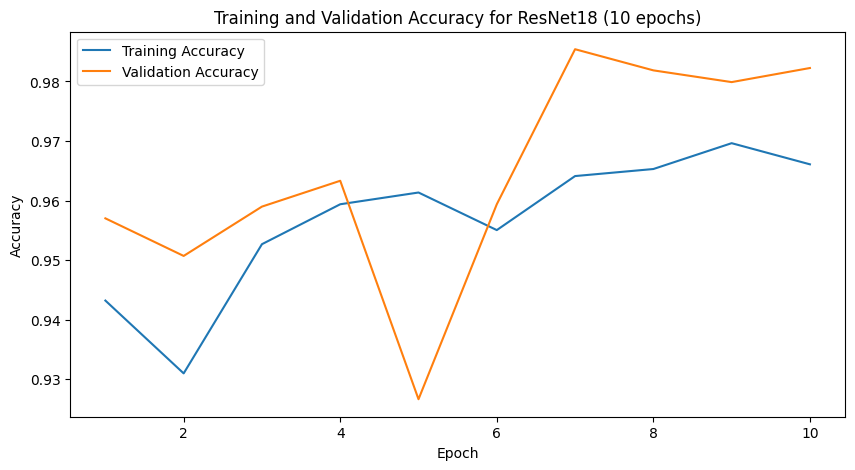

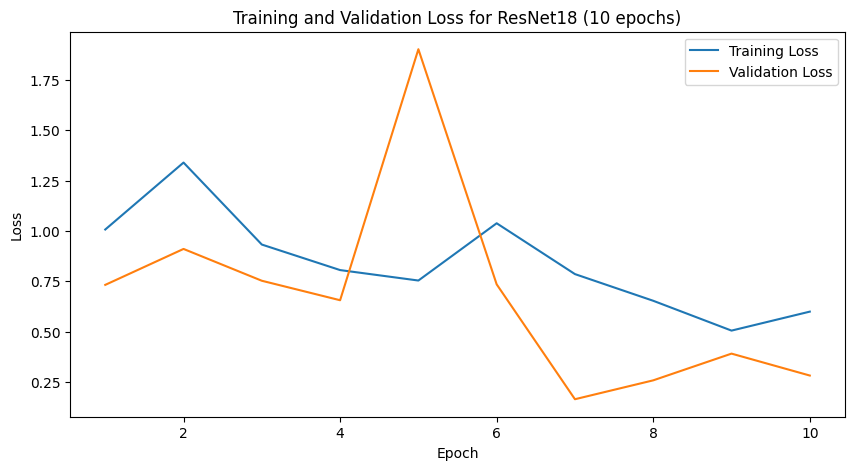

In [36]:
# Move the accuracies to CPU
train_acc_resnet18_cpu = [acc.cpu().numpy() for acc in train_acc_resnet18]
valid_acc_resnet18_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet18]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet18_cpu) + 1), train_acc_resnet18_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet18_cpu) + 1), valid_acc_resnet18_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet18 (10 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet18) + 1), train_loss_resnet18, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet18) + 1), valid_loss_resnet18, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet18 (10 epochs)')
plt.legend()
plt.show()

****RESNET34****

In [37]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 157MB/s]


In [38]:
# Modify the model head for fine-tuning
num_features = model.fc.in_features

num_classes = 2

model.fc = nn.Linear(num_features, 2)

# Replace the last fully connected layer with LORALayer for adaptation
model.fc = LORALayer(model.fc)

In [39]:
print(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
model_5_ep, train_acc_resnet34, valid_acc_resnet34, train_loss_resnet34, valid_loss_resnet34 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=5)


Epoch 1/5
----------
train Loss: 12.8872 Acc: 0.7374
valid Loss: 7.0788 Acc: 0.7705
Epoch 2/5
----------
train Loss: 3.0193 Acc: 0.8576
valid Loss: 1.2833 Acc: 0.9065
Epoch 3/5
----------
train Loss: 1.7313 Acc: 0.8998
valid Loss: 0.6413 Acc: 0.9381
Epoch 4/5
----------
train Loss: 0.8085 Acc: 0.9353
valid Loss: 0.6173 Acc: 0.9440
Epoch 5/5
----------
train Loss: 0.7368 Acc: 0.9381
valid Loss: 0.3442 Acc: 0.9645


In [41]:
print("Evaluating resnet34 on the test set...")
evaluate_model(model_5_ep, dataloaders['test'])

Evaluating resnet34 on the test set...
Accuracy: 0.8667
Precision: 0.8571
Recall: 0.8800
F1-score: 0.8684


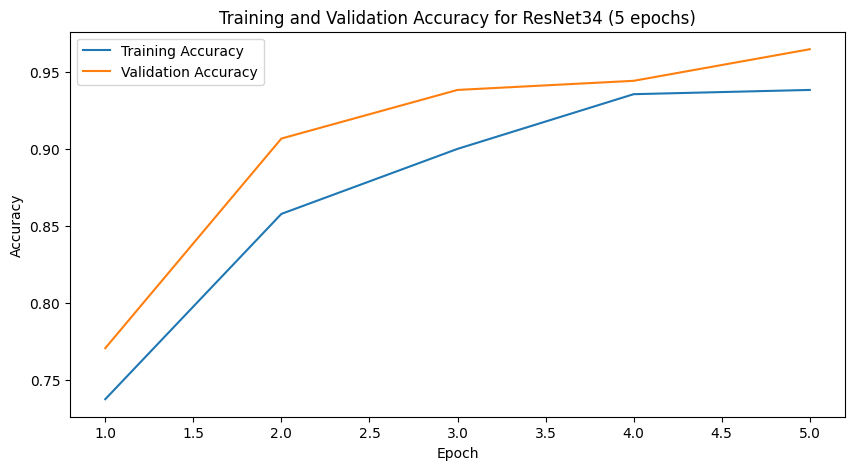

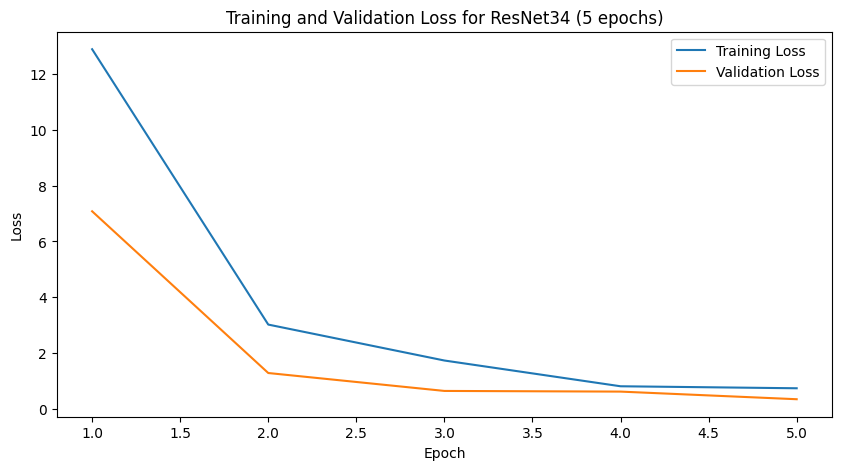

In [42]:
# Move the accuracies to CPU
train_acc_resnet34_cpu = [acc.cpu().numpy() for acc in train_acc_resnet34]
valid_acc_resnet34_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet34]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet34_cpu) + 1), train_acc_resnet34_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet34_cpu) + 1), valid_acc_resnet34_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet34 (5 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet34) + 1), train_loss_resnet34, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet34) + 1), valid_loss_resnet34, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet34 (5 epochs)')
plt.legend()
plt.show()

In [43]:
model_10_ep, train_acc_resnet34, valid_acc_resnet34, train_loss_resnet34, valid_loss_resnet34 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=10)


Epoch 1/10
----------
train Loss: 0.4589 Acc: 0.9594
valid Loss: 0.0861 Acc: 0.9890
Epoch 2/10
----------
train Loss: 0.4444 Acc: 0.9570
valid Loss: 0.2546 Acc: 0.9716
Epoch 3/10
----------
train Loss: 0.2849 Acc: 0.9661
valid Loss: 0.1374 Acc: 0.9838
Epoch 4/10
----------
train Loss: 0.2762 Acc: 0.9712
valid Loss: 0.0931 Acc: 0.9890
Epoch 5/10
----------
train Loss: 0.3307 Acc: 0.9649
valid Loss: 0.1666 Acc: 0.9811
Epoch 6/10
----------
train Loss: 0.4021 Acc: 0.9610
valid Loss: 0.0871 Acc: 0.9874
Epoch 7/10
----------
train Loss: 0.3089 Acc: 0.9669
valid Loss: 0.1427 Acc: 0.9850
Epoch 8/10
----------
train Loss: 0.3010 Acc: 0.9700
valid Loss: 0.1036 Acc: 0.9870
Epoch 9/10
----------
train Loss: 0.1527 Acc: 0.9779
valid Loss: 0.1101 Acc: 0.9862
Epoch 10/10
----------
train Loss: 0.2257 Acc: 0.9728
valid Loss: 0.0595 Acc: 0.9909


In [44]:
print("Evaluating resnet34 on the test set...")
evaluate_model(model_10_ep, dataloaders['test'])

Evaluating resnet34 on the test set...
Accuracy: 0.8967
Precision: 0.9281
Recall: 0.8600
F1-score: 0.8927


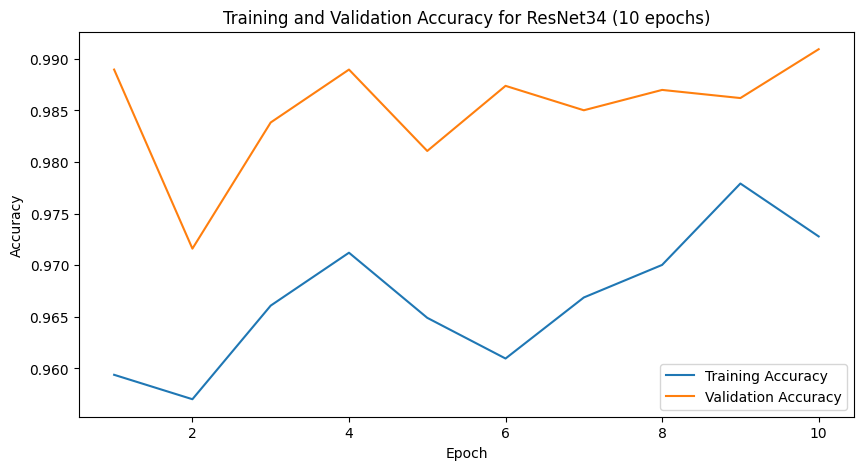

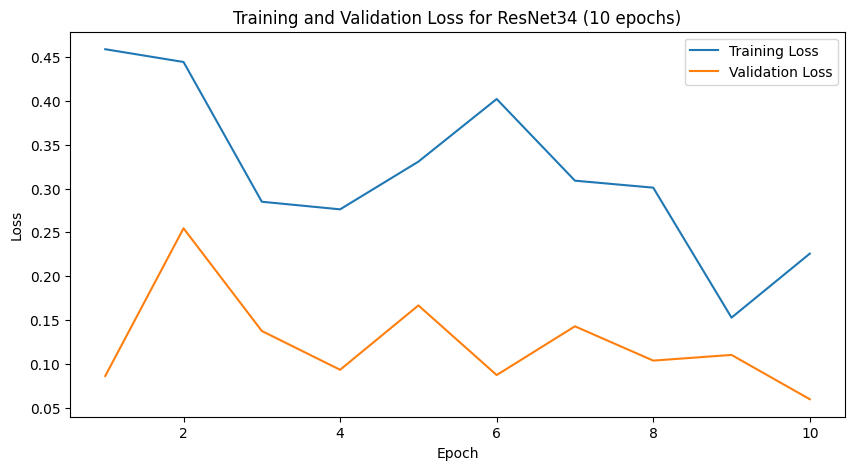

In [45]:
# Move the accuracies to CPU
train_acc_resnet34_cpu = [acc.cpu().numpy() for acc in train_acc_resnet34]
valid_acc_resnet34_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet34]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet34_cpu) + 1), train_acc_resnet34_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet34_cpu) + 1), valid_acc_resnet34_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet34 (10 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet34) + 1), train_loss_resnet34, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet34) + 1), valid_loss_resnet34, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet34 (10 epochs)')
plt.legend()
plt.show()

**RESNET50**

In [46]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


In [47]:
# Modify the model head for fine-tuning
num_features = model.fc.in_features

num_classes = 2

model.fc = nn.Linear(num_features, 2)

# Replace the last fully connected layer with LORALayer for adaptation
model.fc = LORALayer(model.fc)

In [48]:
print(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
model_5_ep, train_acc_resnet50, valid_acc_resnet50, train_loss_resnet50, valid_loss_resnet50 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=5)


Epoch 1/5
----------
train Loss: 15.1782 Acc: 0.7244
valid Loss: 5.9858 Acc: 0.8482
Epoch 2/5
----------
train Loss: 6.7907 Acc: 0.8387
valid Loss: 5.5210 Acc: 0.8734
Epoch 3/5
----------
train Loss: 4.7365 Acc: 0.8738
valid Loss: 3.7821 Acc: 0.9054
Epoch 4/5
----------
train Loss: 4.5547 Acc: 0.8888
valid Loss: 7.0179 Acc: 0.8328
Epoch 5/5
----------
train Loss: 2.8322 Acc: 0.9219
valid Loss: 2.8545 Acc: 0.9294


In [50]:
print("Evaluating resnet50 on the test set...")
evaluate_model(model_5_ep, dataloaders['test'])

Evaluating resnet50 on the test set...
Accuracy: 0.8100
Precision: 0.8974
Recall: 0.7000
F1-score: 0.7865


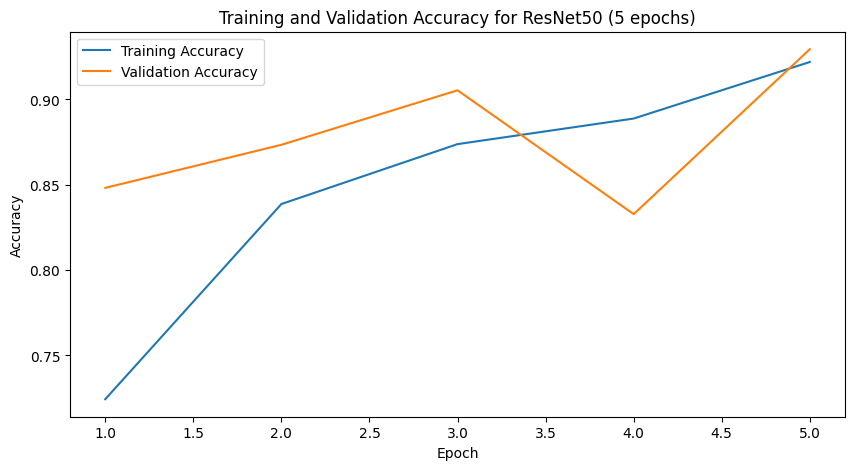

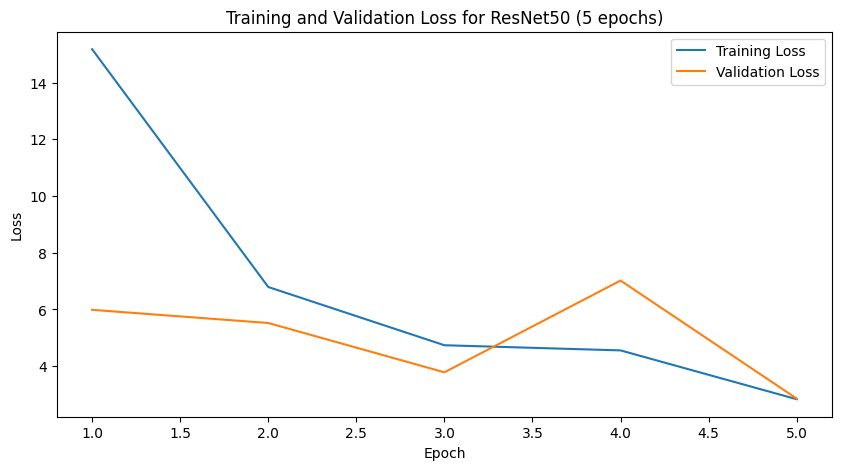

In [51]:
# Move the accuracies to CPU
train_acc_resnet50_cpu = [acc.cpu().numpy() for acc in train_acc_resnet50]
valid_acc_resnet50_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet50]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet50_cpu) + 1), train_acc_resnet50_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet50_cpu) + 1), valid_acc_resnet50_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet50 (5 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet50) + 1), train_loss_resnet50, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet50) + 1), valid_loss_resnet50, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50 (5 epochs)')
plt.legend()
plt.show()

In [52]:
model_10_ep, train_acc_resnet50, valid_acc_resnet50, train_loss_resnet50, valid_loss_resnet50 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=10)


Epoch 1/10
----------
train Loss: 2.6492 Acc: 0.9302
valid Loss: 7.3796 Acc: 0.8478
Epoch 2/10
----------
train Loss: 2.3180 Acc: 0.9401
valid Loss: 2.1380 Acc: 0.9468
Epoch 3/10
----------
train Loss: 1.7267 Acc: 0.9495
valid Loss: 1.1973 Acc: 0.9562
Epoch 4/10
----------
train Loss: 1.8237 Acc: 0.9416
valid Loss: 2.2999 Acc: 0.9310
Epoch 5/10
----------
train Loss: 1.1422 Acc: 0.9641
valid Loss: 0.9949 Acc: 0.9681
Epoch 6/10
----------
train Loss: 0.9420 Acc: 0.9673
valid Loss: 0.3654 Acc: 0.9823
Epoch 7/10
----------
train Loss: 0.7359 Acc: 0.9732
valid Loss: 0.6829 Acc: 0.9744
Epoch 8/10
----------
train Loss: 1.4017 Acc: 0.9614
valid Loss: 0.4064 Acc: 0.9826
Epoch 9/10
----------
train Loss: 1.1305 Acc: 0.9657
valid Loss: 0.6852 Acc: 0.9720
Epoch 10/10
----------
train Loss: 0.8740 Acc: 0.9692
valid Loss: 0.2376 Acc: 0.9894


In [53]:
print("Evaluating resnet50 on the test set...")
evaluate_model(model_10_ep, dataloaders['test'])

Evaluating resnet50 on the test set...
Accuracy: 0.8800
Precision: 0.9130
Recall: 0.8400
F1-score: 0.8750


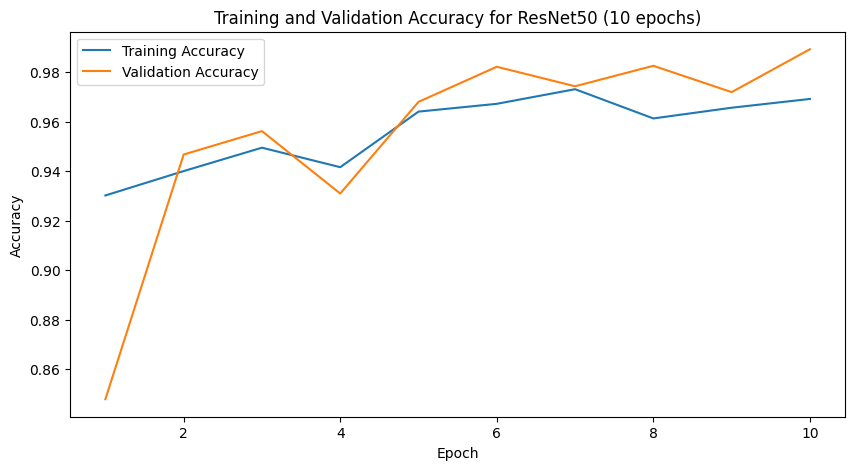

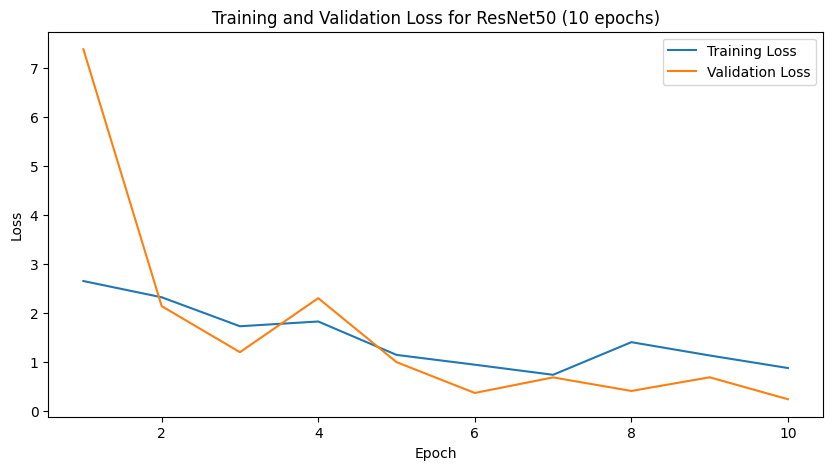

In [54]:
# Move the accuracies to CPU
train_acc_resnet50_cpu = [acc.cpu().numpy() for acc in train_acc_resnet50]
valid_acc_resnet50_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet50]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet50_cpu) + 1), train_acc_resnet50_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet50_cpu) + 1), valid_acc_resnet50_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet50 (10 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet50) + 1), train_loss_resnet50, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet50) + 1), valid_loss_resnet50, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50 (10 epochs)')
plt.legend()
plt.show()